### Notebook that generates the graph for the 4 most popular vulnerabilities in the dataset

In [1]:
tools = [
    'Elysium', 
    'sGuard', 
    'sGuardPlus',
    'SmartFix', 
    'SmartShield', 
    "SolGPT" ,
    'TIPS', 
]

In [2]:
import os

#collecting contracts name
dataset='smartbugs/data_analysis/'
results_path='../results/'
contracts_path=os.path.join(results_path,dataset,'contracts.csv')
storage_path=os.path.join(results_path,dataset)

import pandas as pd
contracts_df = pd.read_csv(contracts_path)
all_patches=pd.read_csv(os.path.join(storage_path,'all_patches_stats.csv'))

#collecting exploits & fomarting
exploits=pd.read_csv(os.path.join(storage_path,'mitigated_exploits_contract_per_tool.csv'))
exploits=exploits.drop(['Total'], axis=1)
exploits['Category']=exploits['Contract'].apply(lambda x: x.split('/')[0])
exploits['Name']=exploits['Contract'].apply(lambda x: x.split('/')[1])
exploits=exploits.drop(['Contract'], axis=1)
exploits=exploits[['Name', 'Category']+tools]

consistent=pd.read_csv(os.path.join(storage_path,'consistent_contracts.csv'))




In [3]:
## final df to gather the infor per contract, category regarding Tool, Detected, Generated, Compilation, Different, Consistent and Mitigated
rq4a_df=pd.DataFrame(columns=['Name', 'Category', 'Tool', 'Detected', 'Generated', 'Compilation', 'Different', 'Consistent', 'Mitigated'])
rq4a_df

,Name,Category,Tool,Detected,Generated,Compilation,Different,Consistent,Mitigated


In [4]:
# Step 1: Add data form all_patches values
for index,row in all_patches.iterrows():
    patch = row['Patch']
    tool=row['Tool']
    category = row['Category']
    original = row['Original']
    comp = row['COMP']
    different = row['DIFF']
    detected = row['Detected']>0
    consistent= (detected==True) and (row['Fixed']-row['Detected']==0)
    #check if the row already exists
    exist = (rq4a_df['Name'] == original) & (rq4a_df['Category'] == category) & (rq4a_df['Tool'] == tool)
    if exist.any():

        diff_true= exist& (rq4a_df['Different']==True)
        if (not diff_true.any()) and (different in [True, False]):
            rq4a_df.loc[exist, 'Different'] = different
        
        comp_true= exist& (rq4a_df['Compilation']==True)
        if (not comp_true.any()) and (comp in [True, False]):
            rq4a_df.loc[exist, 'Compilation'] = comp
        
        detected_true= exist& (rq4a_df['Detected']==True)
        if (not detected_true.any()) and (detected in [True, False]):
            rq4a_df.loc[exist, 'Detected'] = detected
        
        consistent_true= exist& (rq4a_df['Consistent']==True)
        if (not consistent_true.any()) and (consistent in [True, False]):
            rq4a_df.loc[exist, 'Consistent'] = consistent
    else:
        new_row = pd.DataFrame({'Name': [original], 'Category': [category],'Generated':[True], 'Tool': [tool], 'Detected': [detected], 'Compilation': [comp], 'Different': [different], 'Consistent': [consistent], 'Mitigated': [None]})
        rq4a_df = pd.concat([rq4a_df, new_row], ignore_index=True)

In [5]:
# Step 2: Add data from mitigated exploit values
for index,row in exploits.iterrows():
    name = row['Name']
    category=row['Category']
    for t in tools:
        if t in row:
            mitigated = row[t]
            exist = (rq4a_df['Name'] == name) & (rq4a_df['Category'] == category) & (rq4a_df['Tool'] == t)
            if exist.any():
                mitigated_true= exist& (rq4a_df['Mitigated']==True)
                if (not mitigated_true.any()) and (mitigated in [True, False]):
                    rq4a_df.loc[exist, 'Mitigated'] = mitigated


In [6]:
#test
rq4a_df[rq4a_df['Name']=='ERC20.sol']

,Name,Category,Tool,Detected,Generated,Compilation,Different,Consistent,Mitigated
41,ERC20.sol,front_running,Elysium,False,True,NaN,False,False,False
514,ERC20.sol,front_running,SmartShield,False,True,NaN,True,False,False
651,ERC20.sol,front_running,SolGPT,False,True,True,True,False,False
791,ERC20.sol,front_running,TIPS,False,True,True,True,False,False


In [7]:
#sanity test
for t in tools:
    print(t)
    print(len(rq4a_df[(rq4a_df['Tool']==t)& (rq4a_df['Consistent']==True)]))

Elysium
53
sGuard
2
sGuardPlus
70
SmartFix
48
SmartShield
38
SolGPT
88
TIPS
81


## Time to prepare some graphs

We start with
### Unchecked Low Level Calls (52 contracts, 20 exploits)

In [8]:
#category in study
category='unchecked_low_level_calls'
category_name='Unchecked Low Level Calls'
category_df= rq4a_df[rq4a_df['Category']==category]
steps = ["Detected", "Generated",'Compilation', "Different", "Consistent", "Mitigated"]
category_per_tool=category_df.groupby("Tool")[steps].sum()
category_per_tool

,Detected,Generated,Compilation,Different,Consistent,Mitigated
Tool,,,,,,
Elysium,19,51,0,43,19,8
SmartFix,0,17,17,17,0,0
SmartShield,20,50,0,50,20,0
SolGPT,51,51,51,51,48,15
TIPS,50,51,50,51,50,18
sGuard,0,48,47,13,0,0
sGuardPlus,28,28,28,28,28,5


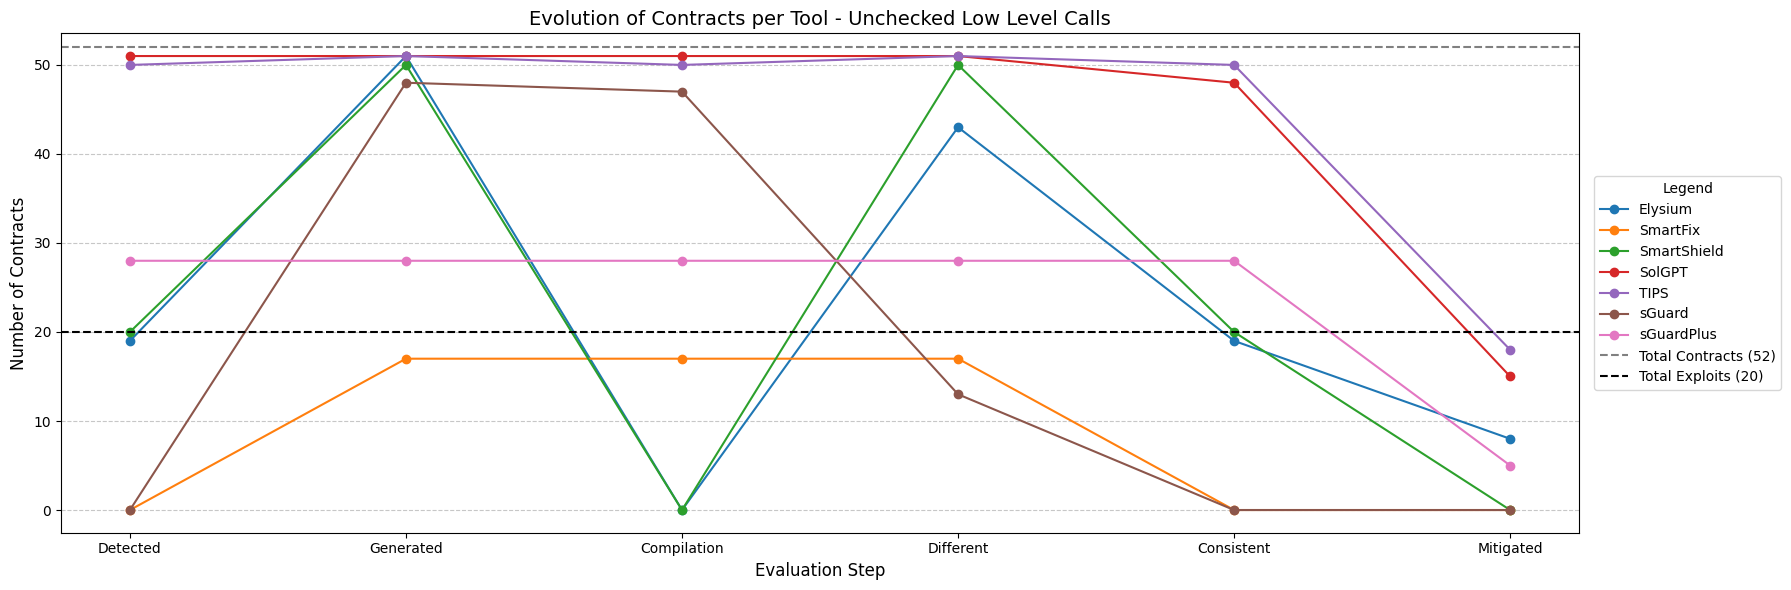

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
# Line plot for each tool
for tool in category_per_tool.index:
    plt.plot(steps, category_per_tool.loc[tool], marker="o", label=tool)
        # Highlight the compilation step for Elysium and SmartShield
    #if tool in ["Elysium", "SmartShield"]:
    #    plt.text(2, ucllc_tools.loc[tool, "Compilation"] + 0.2, "Compilation: False", 
    #             horizontalalignment='center', color='red')


# Add constant lines for total contracts and exploits
total_contracts = contracts_df[contracts_df['Category'] == category].shape[0]
total_exploits = 20

# Add horizontal lines
plt.axhline(total_contracts, color='grey', linestyle='--', label=f'Total Contracts ({total_contracts})')
plt.axhline(total_exploits, color='black', linestyle='--', label=f'Total Exploits ({total_exploits})')

# Customize plot
plt.title(f"Evolution of Contracts per Tool - {category_name}", fontsize=14)
plt.xlabel("Evaluation Step", fontsize=12)
plt.ylabel("Number of Contracts", fontsize=12)
plt.legend(title='Legend', bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(storage_path,f'plots/rq4a_{category}_evolution.pdf'))
plt.show()

### Moving on with Reentrancy (31 contracts, 26 exploits)

In [10]:
#category in study
category='reentrancy'
category_name='Reentrancy'
category_df= rq4a_df[rq4a_df['Category']==category]
steps = ["Detected", "Generated",'Compilation', "Different", "Consistent", "Mitigated"]
category_per_tool=category_df.groupby("Tool")[steps].sum()
category_per_tool

,Detected,Generated,Compilation,Different,Consistent,Mitigated
Tool,,,,,,
Elysium,10,18,0,17,10,3
SmartFix,27,28,28,28,27,25
SmartShield,28,30,0,30,6,0
SolGPT,31,31,31,31,28,25
TIPS,30,31,30,31,29,25
sGuard,31,31,31,31,0,26
sGuardPlus,28,28,28,28,28,25


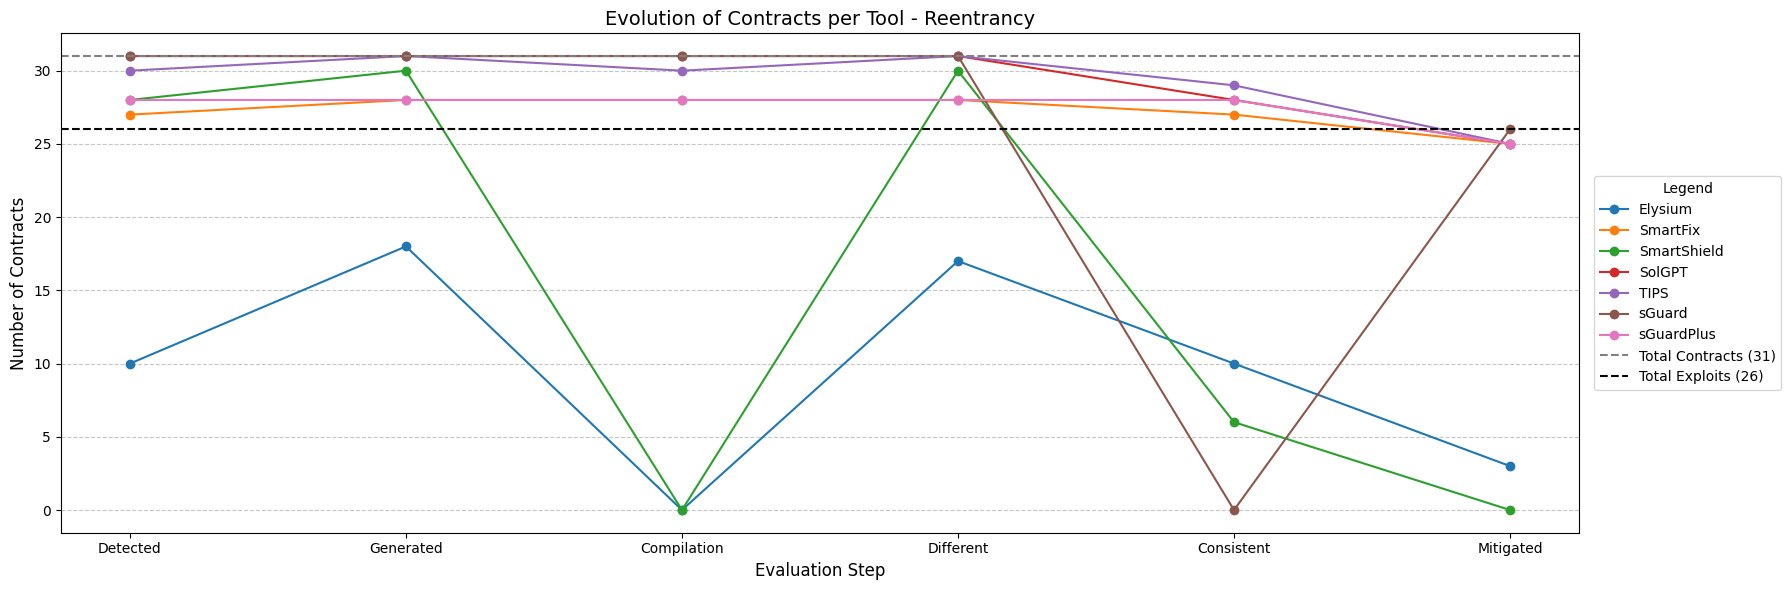

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
# Line plot for each tool
for tool in category_per_tool.index:
    plt.plot(steps, category_per_tool.loc[tool], marker="o", label=tool)
        # Highlight the compilation step for Elysium and SmartShield
    #if tool in ["Elysium", "SmartShield"]:
    #    plt.text(2, ucllc_tools.loc[tool, "Compilation"] + 0.2, "Compilation: False", 
    #             horizontalalignment='center', color='red')


# Add constant lines for total contracts and exploits
total_contracts = contracts_df[contracts_df['Category'] == category].shape[0]
total_exploits = 26

# Add horizontal lines
plt.axhline(total_contracts, color='grey', linestyle='--', label=f'Total Contracts ({total_contracts})')
plt.axhline(total_exploits, color='black', linestyle='--', label=f'Total Exploits ({total_exploits})')

# Customize plot
plt.title(f"Evolution of Contracts per Tool - {category_name}", fontsize=14)
plt.xlabel("Evaluation Step", fontsize=12)
plt.ylabel("Number of Contracts", fontsize=12)
plt.legend(title='Legend', bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(storage_path,f'plots/rq4a_{category}_evolution.pdf'))
plt.show()

### Third most famous Access Control (18 contracts, 16 exploits)

In [12]:
#category in study
category='access_control'
category_name='Access Control'
category_df= rq4a_df[rq4a_df['Category']==category]
steps = ["Detected", "Generated",'Compilation', "Different", "Consistent", "Mitigated"]
category_per_tool=category_df.groupby("Tool")[steps].sum()
category_per_tool

,Detected,Generated,Compilation,Different,Consistent,Mitigated
Tool,,,,,,
Elysium,10,17,0,14,10,9
SmartFix,11,13,13,13,9,10
SmartShield,0,15,0,14,0,5
SolGPT,9,17,16,17,6,11
TIPS,2,17,17,17,2,2
sGuard,2,13,13,6,2,3
sGuardPlus,3,8,8,8,3,4


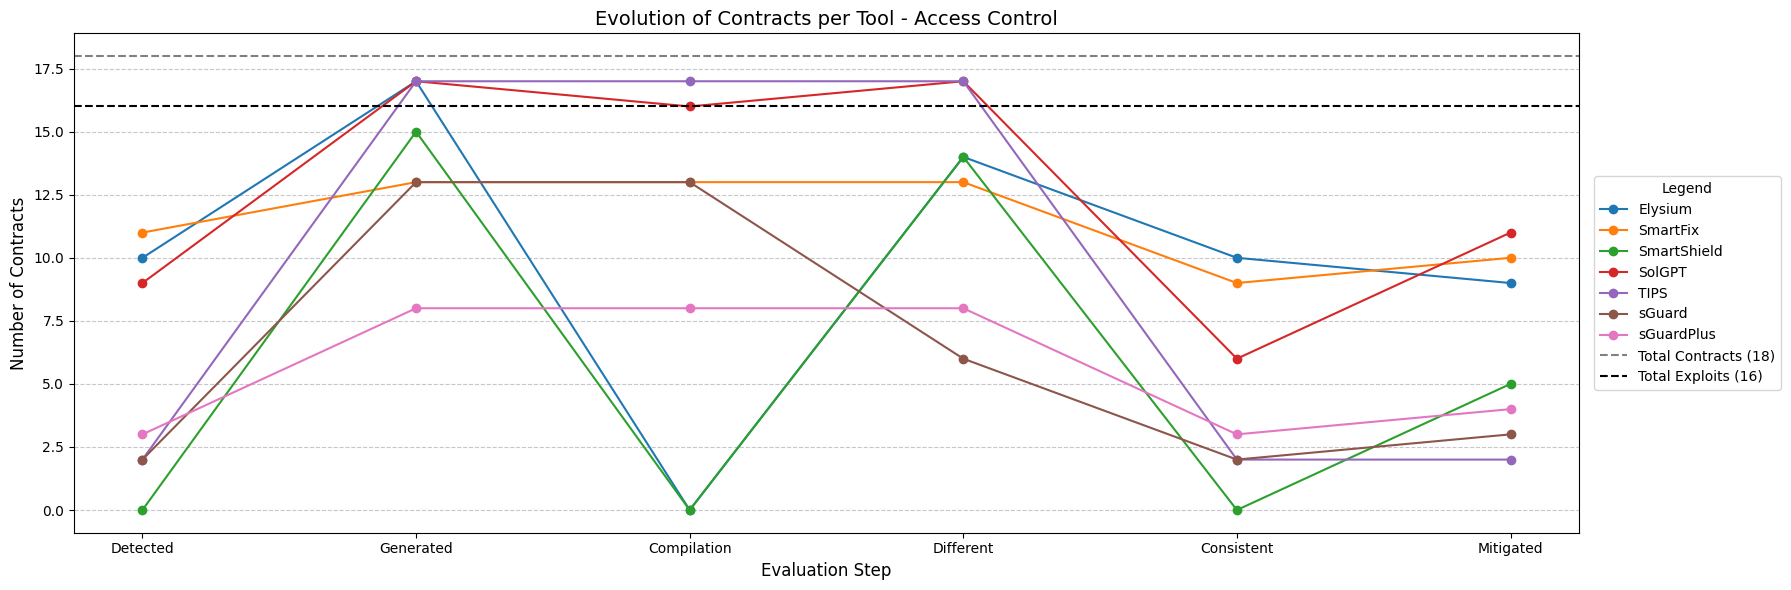

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
# Line plot for each tool
for tool in category_per_tool.index:
    plt.plot(steps, category_per_tool.loc[tool], marker="o", label=tool)
        # Highlight the compilation step for Elysium and SmartShield
    #if tool in ["Elysium", "SmartShield"]:
    #    plt.text(2, ucllc_tools.loc[tool, "Compilation"] + 0.2, "Compilation: False", 
    #             horizontalalignment='center', color='red')


# Add constant lines for total contracts and exploits
total_contracts = contracts_df[contracts_df['Category'] == category].shape[0]
total_exploits = 16

# Add horizontal lines
plt.axhline(total_contracts, color='grey', linestyle='--', label=f'Total Contracts ({total_contracts})')
plt.axhline(total_exploits, color='black', linestyle='--', label=f'Total Exploits ({total_exploits})')

# Customize plot
plt.title(f"Evolution of Contracts per Tool - {category_name}", fontsize=14)
plt.xlabel("Evaluation Step", fontsize=12)
plt.ylabel("Number of Contracts", fontsize=12)
plt.legend(title='Legend', bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.xticks(rotation=45)
plt.savefig(os.path.join(storage_path,f'plots/rq4a_{category}_evolution.pdf'))
plt.tight_layout()
plt.show()

## Final one, Arithmetic (15 contracts, 13 exploits)

In [14]:
#category in study
category='arithmetic'
category_name='Arithmetic'
category_df= rq4a_df[rq4a_df['Category']==category]
steps = ["Detected", "Generated",'Compilation', "Different", "Consistent", "Mitigated"]
category_per_tool=category_df.groupby("Tool")[steps].sum()
category_per_tool

,Detected,Generated,Compilation,Different,Consistent,Mitigated
Tool,,,,,,
Elysium,14,15,0,14,14,7
SmartFix,13,13,13,13,12,12
SmartShield,12,15,0,15,12,4
SolGPT,0,14,14,14,0,9
TIPS,0,15,15,15,0,0
sGuard,2,2,2,2,0,2
sGuardPlus,11,11,11,11,11,10


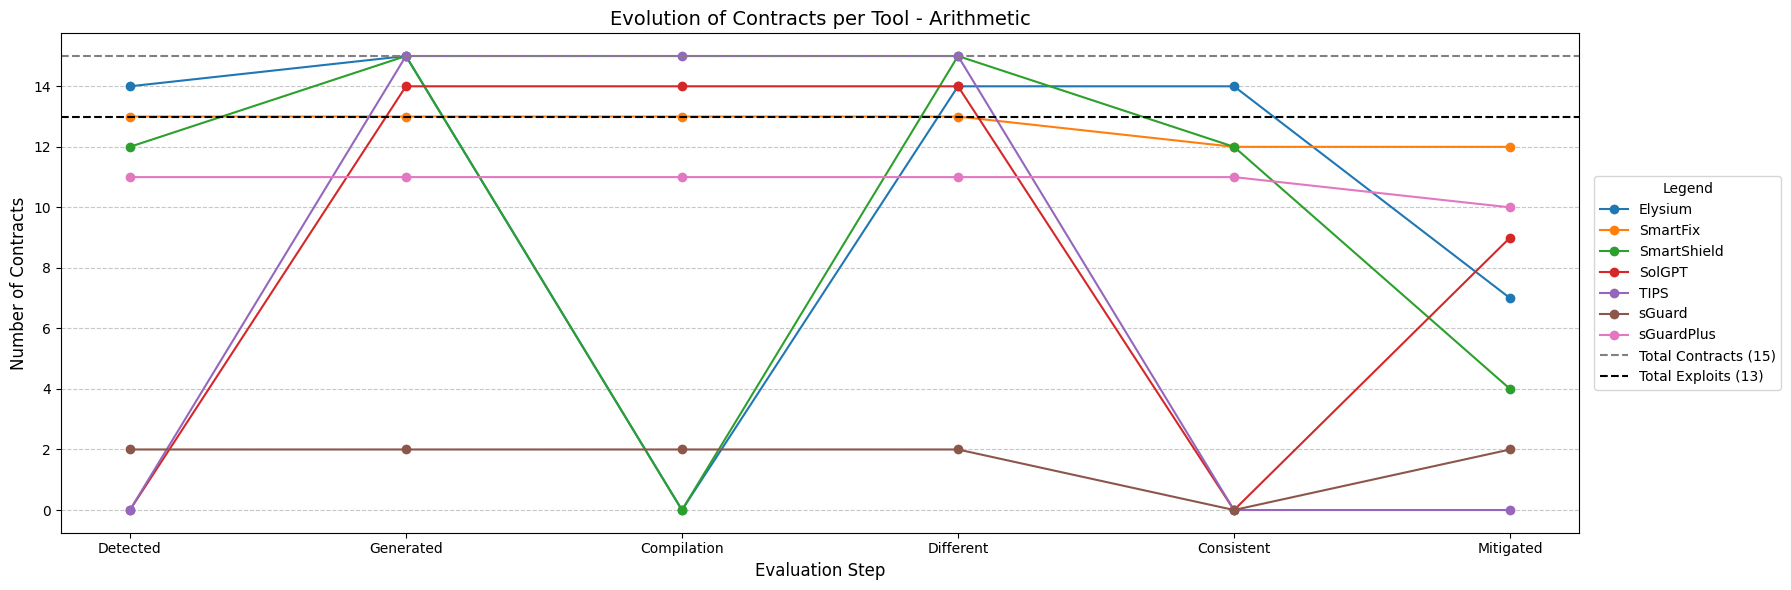

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
# Line plot for each tool
for tool in category_per_tool.index:
    plt.plot(steps, category_per_tool.loc[tool], marker="o", label=tool)
        # Highlight the compilation step for Elysium and SmartShield
    #if tool in ["Elysium", "SmartShield"]:
    #    plt.text(2, ucllc_tools.loc[tool, "Compilation"] + 0.2, "Compilation: False", 
    #             horizontalalignment='center', color='red')


# Add constant lines for total contracts and exploits
total_contracts = contracts_df[contracts_df['Category'] == category].shape[0]
total_exploits = 13

# Add horizontal lines
plt.axhline(total_contracts, color='grey', linestyle='--', label=f'Total Contracts ({total_contracts})')
plt.axhline(total_exploits, color='black', linestyle='--', label=f'Total Exploits ({total_exploits})')

# Customize plot
plt.title(f"Evolution of Contracts per Tool - {category_name}", fontsize=14)
plt.xlabel("Evaluation Step", fontsize=12)
plt.ylabel("Number of Contracts", fontsize=12)
plt.legend(title='Legend', bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.xticks(rotation=45)
plt.savefig(os.path.join(storage_path,f'plots/rq4a_{category}_evolution.pdf'))
plt.tight_layout()
plt.show()